**Importing Dataset From The Google Drive**

In [1]:
import tensorflow
print(tensorflow.__version__)

2.14.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Managing GPU & RAM**

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

**Libraries Import**

In [4]:
# import the libraries as shown below

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping


from tensorflow.keras.models import Sequential
from collections import Counter
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob

import tensorflow as tf
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import ast #to easily read out class text file that contains some unknwn syntax.
import scipy   #to upscale the image
import matplotlib.pyplot as plt
import cv2
from PIL import Image

**Resize Images & Copy Dataset Path**

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224

train_path = '/content/drive/MyDrive/MRI BT2/Training'
validate_path = '/content/drive/MyDrive/MRI BT2/Validate'
test_path = '/content/drive/MyDrive/MRI BT2/Testing'

**Getting The Size of The Training Dataset**

In [6]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/MRI BT2/Training/*')
print(folders)

['/content/drive/MyDrive/MRI BT2/Training/meningioma', '/content/drive/MyDrive/MRI BT2/Training/glioma', '/content/drive/MyDrive/MRI BT2/Training/pituitary', '/content/drive/MyDrive/MRI BT2/Training/notumor']


**Image Data Generator**

In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

validate_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

**Training Dataset - Augmentation Rules**




In [8]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 color_mode = 'rgb',
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

Found 5621 images belonging to 4 classes.


**Validating Dataset - Augmentation Rules**




In [ ]:
validate_set = test_datagen.flow_from_directory(validate_path,
                                                target_size = (224, 224),
                                                color_mode = 'rgb',
                                                batch_size = 32,
                                                class_mode = 'categorical',
                                                shuffle = True)

Found 701 images belonging to 4 classes.


**Testing Dataset - Augmentation Rules**




In [ ]:
testing_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            color_mode = 'rgb',
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 701 images belonging to 4 classes.


**Labels**

In [ ]:
labels = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validate_set.class_indices)
print('Test  :', testing_set.class_indices)

Train : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Valid : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test  : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Calculating Weights

In [ ]:
def compute_weights(dataset):
  counter = Counter(dataset.classes)
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()}
  return class_weights

**ResNet-50 V2 Model**

In [ ]:
# Import the ResNet50 library as shown below and add preprocessing layer to the front of ResNet
# Here we will be using imagenet weights

inputs = layers.Input(shape = (img_height,img_width,3))
base_model = ResNet50V2(include_top = False,
                   weights = "imagenet",
                   input_tensor = inputs,
                   input_shape = (img_height,img_width,3),
                   pooling = 'avg')




94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
# view the structure of the model
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

**Transfer Learning - ImageNet Weights Are Kept The Same**

In [ ]:
# our layers - you can add more if you want
base_output = base_model.output

x = layers.Dense(units = 1280, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 640, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)

outputs = layers.Dense(units = len(folders), activation = 'softmax', name = 'final_softmax')(x)

model_resnet = tf.keras.Model(inputs, outputs)

# Transfer Leraning: base_model.trainable = False
# Fine-Tuning: base_model.trainable = True
base_model.trainable = True

# Fine Tuning
#for layer in base_model.layers[:18]:
#    layer.trainable = False
#for layer in base_model.layers[18:]:
#    layer.trainable = True


model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

**Model Compiling = Loss, Optimizer & Metrics**

In [ ]:
# tell the model what cost and optimization method to use
model_resnet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


**Fitting The Model**

In [ ]:
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-5)

early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

## Compute weights :
class_weights = compute_weights(training_set)

# fit the model
# Run the cell. It will take some time to execute
training_history = model_resnet.fit(
  training_set,
  validation_data=validate_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(validate_set),
  class_weight=class_weights,
  callbacks = callbacks_list)

Epoch 1/20
176/176 [==============================] - 4058s 23s/step - loss: 1.2495 - accuracy: 0.7744 - val_loss: 303.6995 - val_accuracy: 0.2853 - lr: 0.0010
Epoch 2/20
176/176 [==============================] - 3909s 22s/step - loss: 0.7387 - accuracy: 0.8760 - val_loss: 0.9847 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 3/20
176/176 [==============================] - 3938s 22s/step - loss: 0.5783 - accuracy: 0.8993 - val_loss: 0.9213 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 4/20
176/176 [==============================] - 3936s 22s/step - loss: 0.5110 - accuracy: 0.9112 - val_loss: 0.6942 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 5/20
176/176 [==============================] - 3920s 22s/step - loss: 0.5466 - accuracy: 0.9030 - val_loss: 0.3900 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 6/20
176/176 [==============================] - 3962s 23s/step - loss: 0.4611 - accuracy: 0.9201 - val_loss: 1.1081 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 7/20
176/176 [==============================

## Saving Model

In [ ]:
## backup before FT
model_resnet.save("/content/drive/MyDrive/models/ResNet50-TF")

**Printing The Trained Model Metrics**

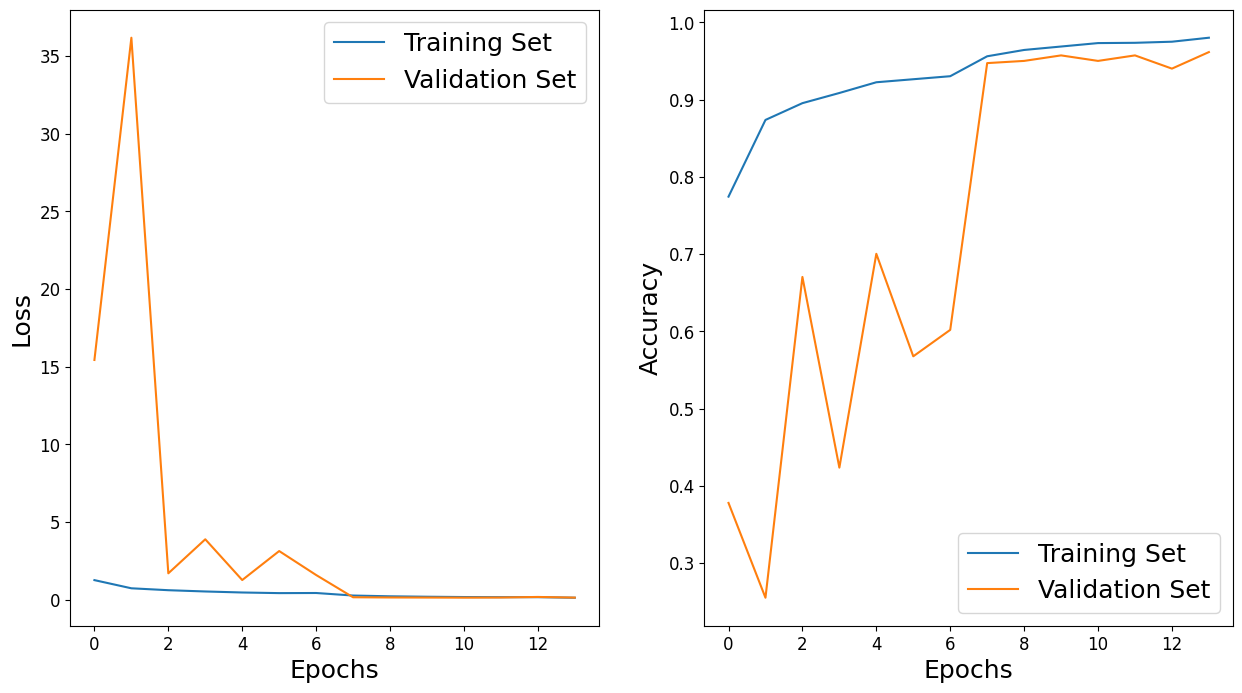

In [ ]:
fig = plt.figure(figsize = (15,8))

fig.add_subplot(1,2,1)
plt.plot(training_history.history["loss"], label = 'Training Set')
plt.plot(training_history.history["val_loss"], label = 'Validation Set')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.legend(fontsize = 18)

fig.add_subplot(1,2,2)
plt.plot(training_history.history["accuracy"], label = 'Training Set')
plt.plot(training_history.history["val_accuracy"], label = 'Validation Set')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend(fontsize = 18)

## Loading The Model

In [ ]:
model = load_model('/content/drive/MyDrive/models/ResNet50-TF')

## Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

**Model's Evaluation**

In [ ]:
model.evaluate(testing_set)

22/22 [==============================] - 108s 5s/step - loss: 1.4930 - accuracy: 0.2739


## Confusion Matrix

**Testing**

The blood cell images include 11 classes :

BNE : Banded NEutrophils
BA : BAsophils
EO : EOsinophils
ERB : ERythroBlasts
LY : LYmphocytes
MMY : MetaMYelocytes
MO : MOnocytes
MY : MYelocytes
PLT : PLaTelets
PMY : Promyelocytes
SNE : Segmented NEutrophils

22/22 [==============================] - 6s 226ms/step


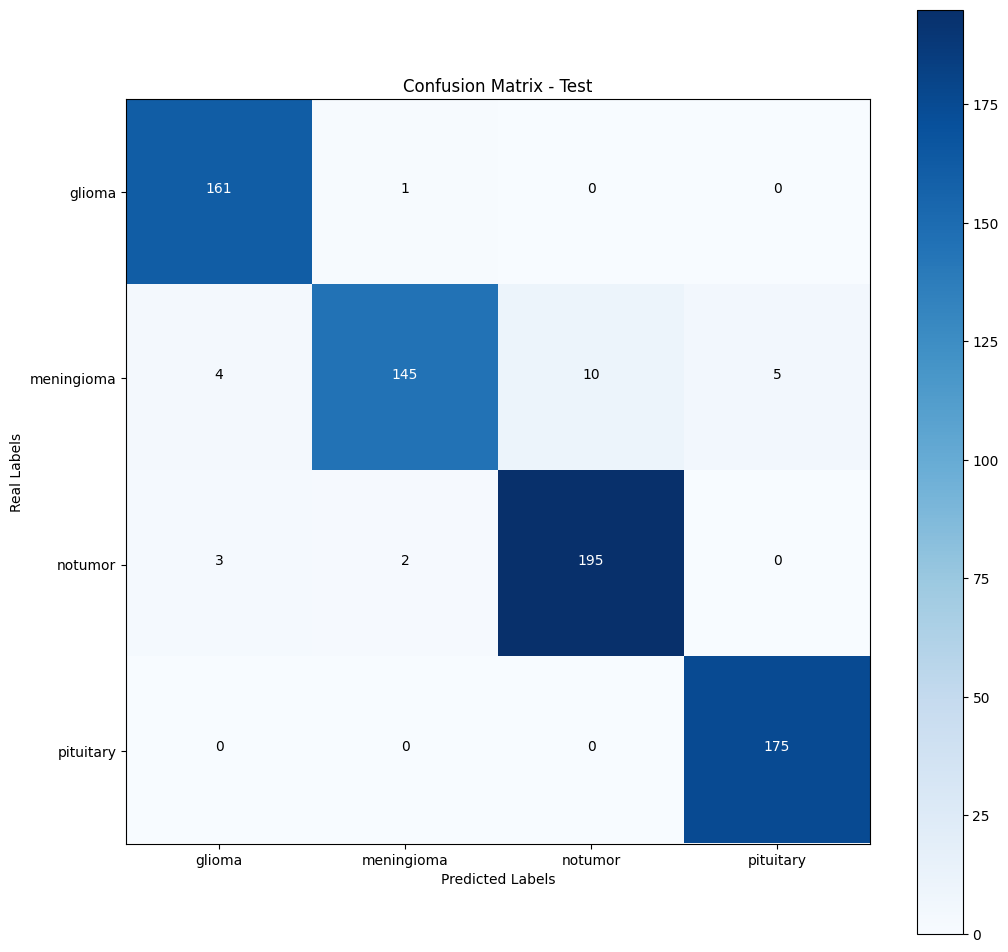

In [ ]:

# Prediction : use the test set (testing_set)
import tensorflow as tf
import itertools
import numpy as np

predictions = model.predict(testing_set)
y_pred = np.argmax(predictions, axis = 1)
#y_test = np.argmax(testing_set.classes, axis = 1)

labels = testing_set.class_indices
#labels = ['BNE', 'BA', 'EO','ERB','LY','MMY','MO','MY','PLT','PMY','SNE']
title = "Test"

# Calculate and display the confucsion matrix
cnf_matrix = confusion_matrix(testing_set.classes, y_pred)
# cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')

# cnf_matrix = confusion_matrix(tf.argmax(testing_set.classes, axis = 1), y_pred, normalize = 'true')

classes = range(len(labels))


plt.figure(figsize = (12,12))
plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion Matrix - "+title)
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i, j in itertools.product(range(cnf_matrix.shape[0]),
                                range(cnf_matrix.shape[1])):
  plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Real Labels')
plt.xlabel('Predicted Labels')
plt.show()


## Classification_Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(testing_set.classes, y_pred,target_names = labels))

              precision    recall  f1-score   support

      glioma       0.96      0.99      0.98       162
  meningioma       0.98      0.88      0.93       164
     notumor       0.95      0.97      0.96       200
   pituitary       0.97      1.00      0.99       175

    accuracy                           0.96       701
   macro avg       0.97      0.96      0.96       701
weighted avg       0.96      0.96      0.96       701



## Visualization of Model

## Install tf.keras.vis

In [ ]:
!pip install tf-keras-vis tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.7 MB/s eta 0:00:00


## Import Libraries

In [ ]:
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


## Load and preprocess images

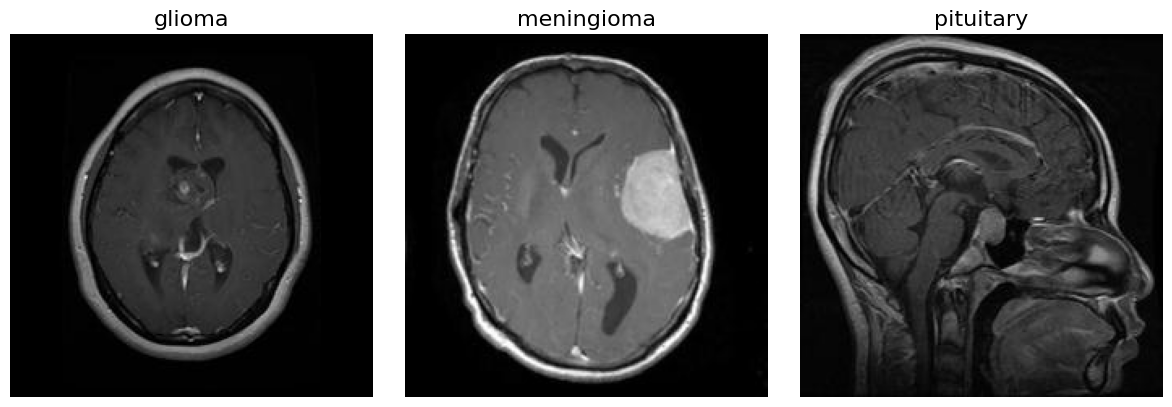

In [ ]:
# Image titles
image_titles = ['glioma', 'meningioma', 'pituitary']

# Load images and Convert them to a Numpy array
img1 = load_img('/content/drive/MyDrive/MRI BT2/Testing/glioma/GL (108).jpg', target_size=(224, 224))
img2 = load_img('/content/drive/MyDrive/MRI BT2/Testing/meningioma/ME (105).jpg', target_size=(224, 224))
img3 = load_img('/content/drive/MyDrive/MRI BT2/Testing/pituitary/PI (105).jpg', target_size=(224, 224))

images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Model modifier

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

TruettTScore function

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0,1,3])


## ScoreCAM

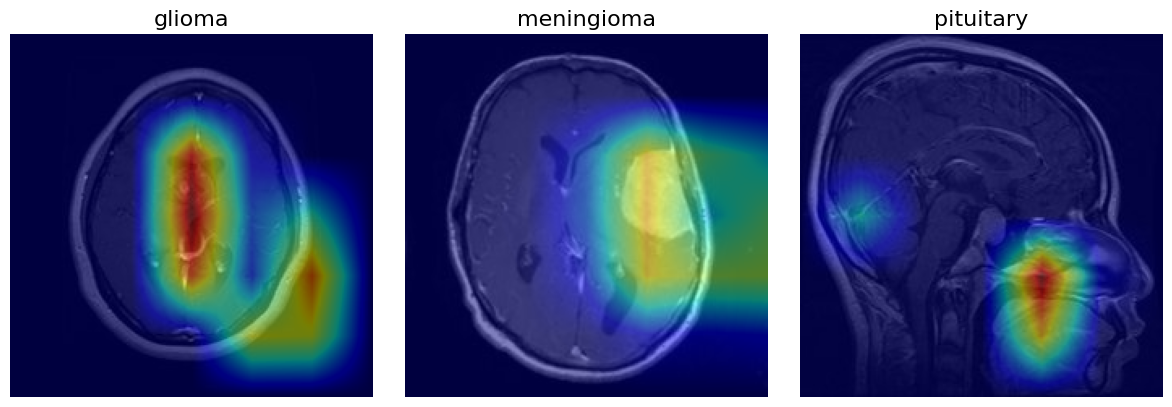

CPU times: user 2.04 s, sys: 31.5 ms, total: 2.07 s
Wall time: 4.83 s


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Gradcam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
#cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

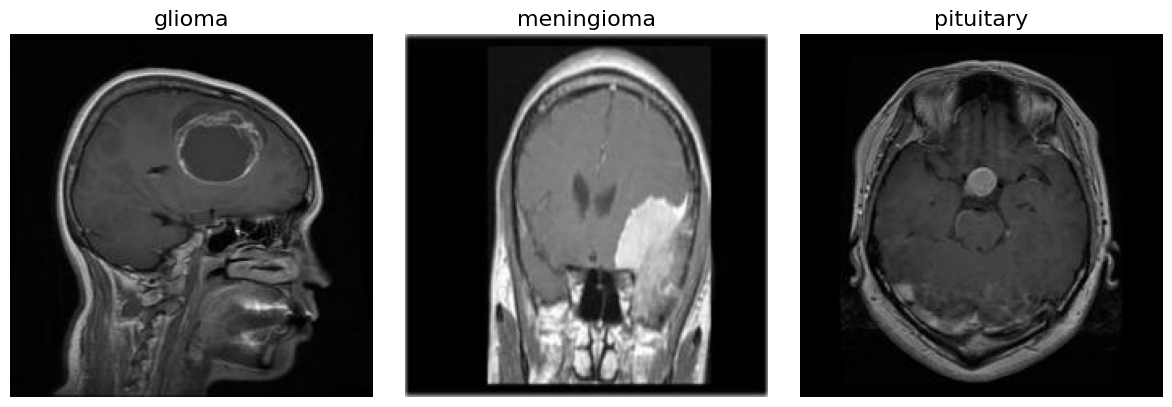

In [ ]:
# Image titles
image_titles = ['glioma', 'meningioma', 'pituitary']

# Load images and Convert them to a Numpy array
img1 = load_img('/content/drive/MyDrive/MRI BT2/Validate/glioma/GL (168).jpg', target_size=(224, 224))
img2 = load_img('/content/drive/MyDrive/MRI BT2/Validate/meningioma/ME (297).jpg', target_size=(224, 224))
img3 = load_img('/content/drive/MyDrive/MRI BT2/Validate/pituitary/PI (182).jpg', target_size=(224, 224))

images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0,1,3])


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
#cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()